# Defines a class to download and manipulate the CRUST1.0 model

In [1]:
%%writefile crust1.py

from __future__ import division
import tarfile
import hashlib
import numpy as np
from fatiando.mesher import Tesseroid
    

class Crust1(object):
    
    layers = """
    water 
    ice 
    upper_sediments
    middle_sediments
    lower_sediments
    upper_crust
    middle_crust
    lower_crust
    mantle
    """.split()
    
    sha256 = '0b41b46fc3e1a76debbbcb66ab407febaeee4dc3033db7a0a24d2bb7c7adfe3e'
    
    def __init__(self, lons, lats, topo, vp, vs, density):
        self.lons, self.lats = lons, lats
        self.topo = topo
        self.vp = vp
        self.vs = vs
        self.density = density
        self.lon, self.lat = np.meshgrid(lons, lats)
        self._make_layers()
        
    def _make_layers(self):
        for i in range(len(self.layers) - 1):
            layer = _Layer(self.lon, self.lat, self.topo[i], self.topo[i + 1],
                           vp=self.vp[i], vs=self.vs[i], density=self.density[i])
            setattr(self, self.layers[i], layer)
        layer = _Layer(self.lon, self.lat, self.topo[-1], None,
                       vp=self.vp[-1], vs=self.vs[-1], density=self.density[-1])
        setattr(self, self.layers[-1], layer)
        
    @property
    def sediment_thickness(self):
        thick = (self.upper_sediments.thickness 
                 + self.middle_sediments.thickness 
                 + self.lower_sediments.thickness)
        return thick
    
    @property
    def crustal_thickness(self):
        thick = (self.sediment_thickness
                 + self.upper_crust.thickness 
                 + self.middle_crust.thickness 
                 + self.lower_crust.thickness)
        return thick
    
    @property
    def moho_depth(self):
        return -self.lower_crust.bottom
    
    def cut(self, area):
        w, e, s, n = area
        imin = np.searchsorted(self.lats, s)
        imax = np.searchsorted(self.lats, n)
        jmin = np.searchsorted(self.lons, w)
        jmax = np.searchsorted(self.lons, e)
        data = self.__class__(
            lons=self.lons[jmin:jmax],
            lats=self.lats[imin:imax],
            topo=self.topo[:, imin:imax, jmin:jmax],
            vp=self.vp[:, imin:imax, jmin:jmax],
            vs=self.vs[:, imin:imax, jmin:jmax],
            density=self.density[:, imin:imax, jmin:jmax])
        return data

    
class _Layer(object):
    def __init__(self, lon, lat, top, bottom=None, **kwargs):
        self.lon = lon
        self.lat = lat
        self.top = top
        self.bottom = bottom
        self.props = kwargs
        for p in self.props:
            setattr(self, p, kwargs[p])
    
    @property
    def thickness(self):
        if self.bottom is None:
            raise ValueError('This layer has no bottom')
        return self.top - self.bottom
    
    @property
    def tesseroids(self):
        ds = (self.lon[0, 1] - self.lon[0, 0])/2
        arrays = [self.lon, self.lat, self.top, self.bottom,
                  self.vp, self.vs, self.density]
        args = zip(*[i.ravel() for i in arrays])
        gen = (Tesseroid(lon - ds, lon + ds, lat - ds, lat + ds,
                         top, bottom, dict(vp=vp, vs=vs, density=density))
               for lon, lat, top, bottom, vp, vs, density in args
               if abs(top - bottom) > 10)
        return gen


def fetch_crust1(fname):
    _check_hash_crust1(fname)
    with tarfile.open(fname, 'r:gz') as arc:
        topo = _extract_file(arc, 'bnds')
        density = _extract_file(arc, 'rho')
        vp = _extract_file(arc, 'vp')
        vs = _extract_file(arc, 'vs')
    lons = np.linspace(-179.5, 179.5, 360)
    lats = np.linspace(-89.5, 89.5, 180)
    return Crust1(lons, lats, topo, vp, vs, density)
    

def _check_hash_crust1(fname):
    sha = _stream_sha(fname)
    msg = ' '.join([
        'Error reading model from file "{}".'.format(fname),
        'Possibly corrupted file',
        '(invalid SHA256 hash "{}").'.format(sha)
        ])
    assert sha == Crust1.sha256, msg
        

def _stream_sha(fname, chunksize=65536):
    hasher = hashlib.sha256()
    with open(fname, 'rb') as f:
        buf = f.read(chunksize)
        while len(buf) > 0:
            hasher.update(buf)
            buf = f.read(chunksize)
    return hasher.hexdigest()

    
def _extract_file(archive, ext):
    f = archive.extractfile('crust1.{}'.format(ext))
    shape = (9, 180, 360)
    # Convert from km, g/cm^3 and km/s to m, kg/m^3 and m/s
    # The slice is to invert the latitude axis. CRUST uses lat from +89.5 to -89.5
    # (North to South). We use South to North.
    data = 1000*np.loadtxt(f, unpack=True).reshape(shape)[:, ::-1, :]
    return data       

Overwriting crust1.py


## Load the model and make some plots

In [2]:
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
from fatiando.vis import mpl, myv
from fatiando import gridder
from IPython.display import Image
from crust1 import fetch_crust1

In [3]:
data = fetch_crust1('../data/crust1.0.tar.gz')

In [4]:
data.layers

['water',
 'ice',
 'upper_sediments',
 'middle_sediments',
 'lower_sediments',
 'upper_crust',
 'middle_crust',
 'lower_crust',
 'mantle']

In [9]:
data.water.density

array([[ 1020.,  1020.,  1020., ...,  1020.,  1020.,  1020.],
       [ 1020.,  1020.,  1020., ...,  1020.,  1020.,  1020.],
       [ 1020.,  1020.,  1020., ...,  1020.,  1020.,  1020.],
       ..., 
       [ 1020.,  1020.,  1020., ...,  1020.,  1020.,  1020.],
       [ 1020.,  1020.,  1020., ...,  1020.,  1020.,  1020.],
       [ 1020.,  1020.,  1020., ...,  1020.,  1020.,  1020.]])

In [10]:
data.upper_crust.vp

array([[ 5900.,  5900.,  5900., ...,  5900.,  5900.,  5900.],
       [ 5900.,  5900.,  5900., ...,  5900.,  5900.,  5900.],
       [ 5900.,  5900.,  5900., ...,  5900.,  5900.,  5900.],
       ..., 
       [ 5000.,  5000.,  5000., ...,  5000.,  5000.,  5000.],
       [ 5000.,  5000.,  5000., ...,  5000.,  5000.,  5000.],
       [ 5000.,  5000.,  5000., ...,  5000.,  5000.,  5000.]])

In [22]:
# Mean crustal density
data.density[5:8].mean(0)

array([[ 2773.33333333,  2773.33333333,  2773.33333333, ...,
         2773.33333333,  2773.33333333,  2773.33333333],
       [ 2773.33333333,  2773.33333333,  2773.33333333, ...,
         2773.33333333,  2773.33333333,  2773.33333333],
       [ 2773.33333333,  2773.33333333,  2773.33333333, ...,
         2773.33333333,  2773.33333333,  2773.33333333],
       ..., 
       [ 2816.66666667,  2816.66666667,  2816.66666667, ...,
         2816.66666667,  2816.66666667,  2816.66666667],
       [ 2816.66666667,  2816.66666667,  2816.66666667, ...,
         2816.66666667,  2816.66666667,  2816.66666667],
       [ 2816.66666667,  2816.66666667,  2816.66666667, ...,
         2816.66666667,  2816.66666667,  2816.66666667]])

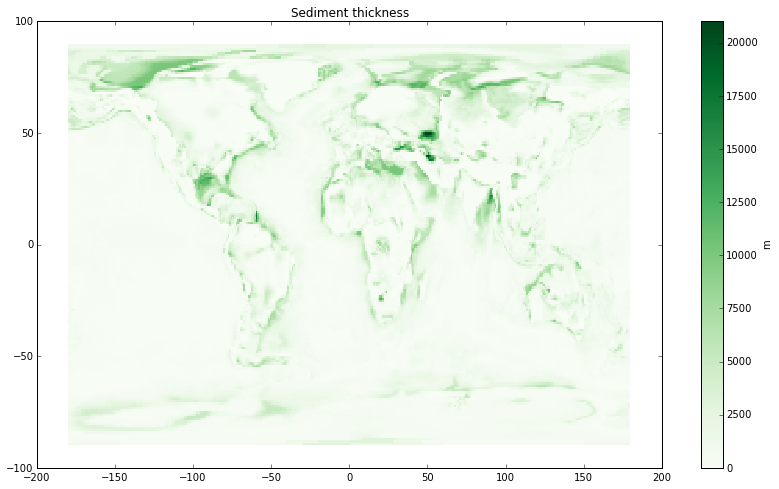

In [5]:
plt.figure(figsize=(14, 8))
plt.title('Sediment thickness')
plt.pcolormesh(data.lons, data.lats, data.sediment_thickness, cmap=plt.cm.Greens)
plt.colorbar().set_label('m')

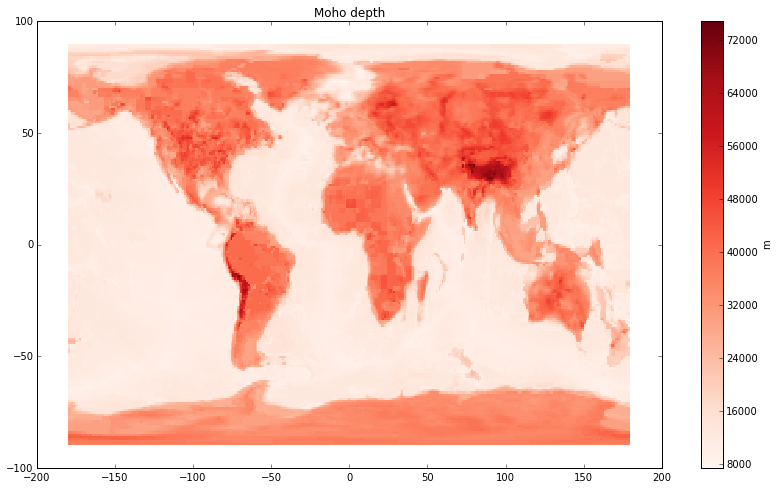

In [6]:
plt.figure(figsize=(14, 8))
plt.title('Moho depth')
plt.pcolormesh(data.lons, data.lats, data.moho_depth, cmap=plt.cm.Reds)
plt.colorbar().set_label('m')

## Cut the model

In [7]:
sa = data.cut((-90, -30, -65, 20))

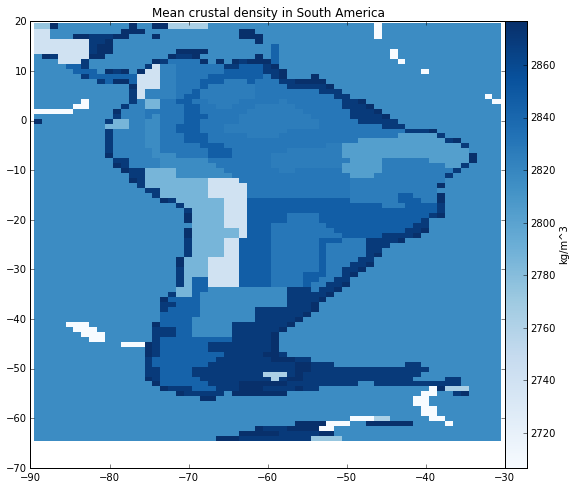

In [24]:
plt.figure(figsize=(10, 8))
plt.title('Mean crustal density in South America')
plt.pcolormesh(sa.lons, sa.lats, sa.density[5:8].mean(0), cmap=plt.cm.Blues)
plt.colorbar(pad=0).set_label('kg/m^3')